In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import detect_utils as du
from  importlib import reload
from skopt import gp_minimize
%pylab inline

/Users/Pawel/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Histogram of Oriented Gradients (HOG)

** Read data **

In [2]:
def get_png_image(path):
    return (mpimg.imread(path)*255).astype(np.uint8)

In [3]:
notcars_files = glob.glob('train_data/non-vehicles/*/*.png')
cars_files = glob.glob('train_data/vehicles/KITTI_extracted/*.png')
cars_files_gti = glob.glob('train_data/vehicles/GTI*/*.png')

In [4]:
split = 0.25
car_split =  split * (len(cars_files_gti) + len(cars_files)) /  len(cars_files)

In [5]:
data_paths={}
data_paths['train_cars'], data_paths['test_cars'] = train_test_split(cars_files, test_size=car_split)
data_paths['train_cars'] += cars_files_gti
data_paths['train_notcars'], data_paths['test_notcars'] = train_test_split(notcars_files, test_size=split)

In [6]:
data_img = {key: [get_png_image(img) for img in data_paths[key]] for key in data_paths.keys()}

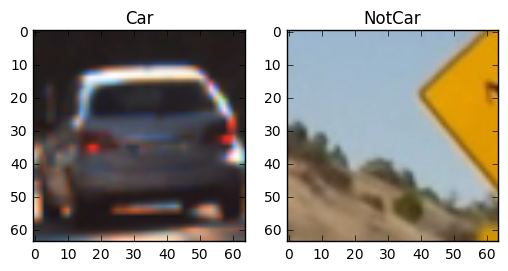

In [7]:
plt.subplot(1, 2, 1)
img_cars = data_img['train_cars'][0]
plt.imshow(img_cars)
plt.title('Car')

plt.subplot(1, 2, 2)
img_notcars = data_img['train_notcars'][0]
plt.imshow(img_notcars)
plt.title('NotCar')

plt.savefig('output_images/car_notcar.jpg')

** Feature selection **

In [8]:
def objective(params, return_clf=False):
    color_space, orient, hog_channel  = params
    C = 1
    cell_per_block = 2
    pix_per_cell = 8
    y_start_stop = [None, None]
    spatial_size = 16
    hist_bins = 16
    hog_feat = True
    spatial_feat = False
    hist_feat = False
    
    spatial_size = (spatial_size, spatial_size)
    features = {key: np.array([du.calc_features(img, params).ravel() for img in data_img[key]]) for key in data_img.keys()}

    X = np.vstack([features['train_cars'], features['test_cars'],
                   features['train_notcars'], features['test_notcars']]).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X


    svc = LinearSVC(C=C)
    if return_clf:
        scaled_X = X_scaler.transform(X)
    # Define the labels vector
        y = np.hstack((np.ones(  len(features['train_cars']) + len(features['test_cars']) ) ,
               np.zeros(len(features['train_notcars']) + len(features['test_notcars']))))
        svc.fit(scaled_X, y)
        return svc, X_scaler
    else:
        X_train = np.vstack((features['train_cars'], features['train_notcars'])).astype(np.float64) 
        X_test = np.vstack((features['test_cars'], features['test_notcars'])).astype(np.float64) 
        scaled_X_train = X_scaler.transform(X_train)
        scaled_X_test = X_scaler.transform(X_test)
    # Define the labels vector
        y_train = np.hstack((np.ones(len(features['train_cars'])), np.zeros(len(features['train_notcars']))))
        y_test = np.hstack((np.ones(len(features['test_cars'])), np.zeros(len(features['test_notcars']))))
        svc.fit(scaled_X_train, y_train)
        err = -svc.score(scaled_X_test, y_test)
        #print (params, err, X.shape[1])
        return err

In [ ]:
space  = [['YCrCb', 'RGB', 'HSV',  'HLS',], # color_space, 'RGB', 'HSV',  'HLS', 
          (6, 12), # orient
          [0, 1, 2, 'ALL'], # hog_channel       
         ]

In [ ]:
%time res_gp = gp_minimize(objective, space, n_calls=20)

In [ ]:
print("""Best parameters:
- color_space=%s
- orient=%d
- hog_channel=%s
""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2],))

In [ ]:
from skopt.plots import plot_convergence
plot_convergence(res_gp);
plt.savefig('output_images/optimization.jpg')

** Example HOG features **

In [ ]:
img_cars = cv2.cvtColor(img_cars, cv2.COLOR_RGB2YCrCb)
img_notcars = cv2.cvtColor(img_notcars, cv2.COLOR_RGB2YCrCb)
imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([img_cars, img_notcars], ['cars', 'not cars']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = du.get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')

In [ ]:
plt.subplot(2, 2, 1)
img_cars = data_img['train_cars'][0]
plt.imshow(img_cars)
plt.title('Car')

ax = plt.subplot(2, 2, 2)
img_notcars = data_img['train_notcars'][0]
ax.imshow(img_notcars)
ax.set_title('NotCar')

In [ ]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title + str(i))
    ax.set_xlim([0, 63])
    ax.set_ylim([0, 63])
    ax.invert_yaxis()
plt.savefig('output_images/HOG_example.jpg')

## Sliding window

In [ ]:
image = mpimg.imread('test_images/test1.jpg')
y_offset = int(image.shape[0]/2)

In [ ]:
windows = [
[96, 30, 150],
[128, 30,  180,],
[144, 70, 250],
[196, 60, None],
]

In [ ]:
y_offset = int(image.shape[0]/2)
boxes = []
for window in windows:
    size, y_start, y_end = window
    y_start += y_offset
    if y_end != None:
        y_end += y_offset
    boxes += du.slide_window(image, xy_window=[size, size], xy_overlap=[0.75, 0.75], y_start_stop=[y_start, y_end])
print(len(boxes))

In [ ]:
img_boxes = du.draw_boxes(image, boxes)

In [ ]:
plt.imshow(img_boxes)
plt.title('Sliding windows')
plt.savefig('output_images/sliding_windows.jpg')

## Pipeline

In [ ]:
params = ['YCrCb', 12, 'ALL']
model, scaler = objective(params, return_clf=True)

In [ ]:
def pipeline(image, plot_figures=False):
    
    y_offset = int(image.shape[0]/2)
    img_bottom = image[y_offset:]
   
    boxes = {}
    for window in windows:
        size, y_start, y_end = window
        boxes[size] = du.slide_window(img_bottom, xy_window=[size, size], 
                                      xy_overlap=[0.8,0.8], y_start_stop=[y_start, y_end])
    box_list = du.search_windows(img_bottom, boxes, model, scaler, params)
    

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = du.add_heat(heat, box_list, y_offset)

    # Apply threshold to help remove false positives
    heat = du.apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = du.draw_labeled_bboxes(np.copy(image), labels)
    
    if plot_figures:
        fig = plt.figure()
        ax = plt.subplot(2, 2, 1)
        ax.imshow(image)
        ax.set_title('Original image')
        
        ax = plt.subplot(2, 2, 2)
        img_boxes = du.draw_boxes(img_bottom, box_list, y_offset)
        ax.imshow(img_boxes)
        ax.set_title('Search area')
        
        ax = plt.subplot(2, 2, 3)
        ax.imshow(heatmap, cmap='hot')
        ax.set_title('Heat map')
        
        ax = plt.subplot(2, 2, 4)
        ax.imshow(draw_img)
        ax.set_title('Car positions')
        
        return img_boxes, heatmap, draw_img
    return draw_img

** Test **

In [ ]:
figs = []
for i in range(1,7):
    image = mpimg.imread('test_images/test%d.jpg'%i)
    fig = pipeline(image, plot_figures=True)
    #plt.savefig('output_images/bboxes_and_heat_%d.jpg'%i)
    figs.append(fig)
    

In [ ]:
# check if feature extraction is working properly
check_fea_ext = False
if check_fea_ext:
    boxes = {}
    size = 128
    for size in [ 64, 96, 128]:
        boxes[size] = du.slide_window(image, xy_window=[size, size], xy_overlap=[0.5,0.5])
    box = boxes[size][10]
    print (box)
    sizes = boxes.keys()
    features = du.get_all_features(image, sizes, params)
    f1 = du.get_feature(features, box, size=size)
    test_image = image[box[0][1]:box[1][1],box[0][0]:box[1][0]]
    
    f2 = du.calc_features(cv2.resize(test_image, (64, 64)), params=params)
    delta =  np.sum(np.abs(f1[:,1:6, 1:6]-f2[:,1:6, 1:6]))/f1[:,1:6, 1:6].sum()
    print (delta)

In [ ]:
fig = figure(figsize=(8, 5))
for i in [1, 2, 3, 4, 5, 6]:
    ax = plt.subplot(3, 2, i)
    ax.imshow(figs[i-1][0])
plt.tight_layout()
plt.savefig('output_images/boxes.jpg')

In [ ]:
plt.imshow(figs[0][0])

In [ ]:
fig = figure(figsize=(8, 10))
k=0
for i in range(6):
    k+=1
    ax = plt.subplot(6, 2, k)
    ax.imshow(figs[i-1][1])
    k+=1
    ax = plt.subplot(6, 2, k)
    ax.imshow(figs[i-1][2])


plt.tight_layout()
plt.savefig('output_images/heat.jpg')

## Pipeline

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
input_video = "project_video.mp4"
output_video = input_video[:-4] + '_with_boxes.mp4'
clip1 = VideoFileClip(input_video)
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)